# EDA on Amazon Labelled Fake Review Dataset 

## Import Libraries

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('default')
sns.set(style='white')
import tensorflow as tf
import numpy as np
import re
import string
import tensorflow as tf
import tensorflow_hub as hub 
import torch
import torch.nn as nn
from transformers import BertTokenizerFast, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from textwrap import wrap
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.nn import CrossEntropyLoss


## Read Dataset 

In [2]:
df = pd.read_csv("fake reviews dataset.csv")

In [3]:
print(df)

                           category  rating label  \
0                Home_and_Kitchen_5     5.0    CG   
1                Home_and_Kitchen_5     5.0    CG   
2                Home_and_Kitchen_5     5.0    CG   
3                Home_and_Kitchen_5     1.0    CG   
4                Home_and_Kitchen_5     5.0    CG   
...                             ...     ...   ...   
40427  Clothing_Shoes_and_Jewelry_5     4.0    OR   
40428  Clothing_Shoes_and_Jewelry_5     5.0    CG   
40429  Clothing_Shoes_and_Jewelry_5     2.0    OR   
40430  Clothing_Shoes_and_Jewelry_5     1.0    CG   
40431  Clothing_Shoes_and_Jewelry_5     5.0    OR   

                                                   text_  
0      Love this!  Well made, sturdy, and very comfor...  
1      love it, a great upgrade from the original.  I...  
2      This pillow saved my back. I love the look and...  
3      Missing information on how to use it, but it i...  
4      Very nice set. Good quality. We have had the s...  
...      

## Model Building

In [4]:

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class FakeReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text_']
        label = 1 if self.data.iloc[idx]['label'] == 'CG' else 0  # 1 for fake, 0 for original

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = FakeReviewDataset(train_df, tokenizer)
test_dataset = FakeReviewDataset(test_df, tokenizer)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
class_weights = torch.tensor([1.0, 1.0]) 
criterion = CrossEntropyLoss(weight=class_weights)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', unit='batches'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}")

# Evaluation loop
model.eval()
all_labels = []
all_predictions = []
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating', unit='batches'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        
        # Collect labels and predictions for the all the test set
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")
test_df.to_csv('test_set.csv', index=False)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

Epoch 1/3, Average Loss: 0.11334315032814975


Epoch 2: 100%|██████████| 4044/4044 [1:55:20<00:00,  1.71s/batches]


Epoch 2/3, Average Loss: 0.037805840118841326


Epoch 3: 100%|██████████| 4044/4044 [1:59:27<00:00,  1.77s/batches]


Epoch 3/3, Average Loss: 0.018216177363305695


Evaluating: 100%|██████████| 1011/1011 [09:51<00:00,  1.71batches/s]


Accuracy on the test set: 97.70%


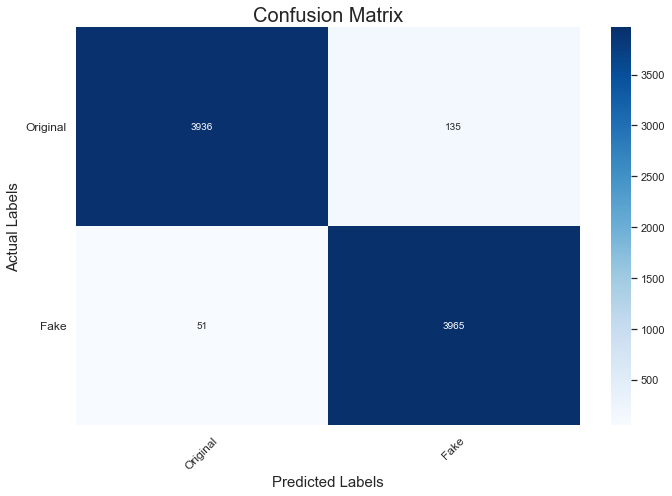

              precision    recall  f1-score   support

    Original       0.99      0.97      0.98      4071
        Fake       0.97      0.99      0.98      4016

    accuracy                           0.98      8087
   macro avg       0.98      0.98      0.98      8087
weighted avg       0.98      0.98      0.98      8087



In [5]:
# Generate classification report
target_names = ['Original', 'Fake']

cm = confusion_matrix(all_labels, all_predictions)
plt.style.use('default')
sns.set(style='white')
plt.figure(figsize=(10, 7)) 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True) 


plt.title('Confusion Matrix', fontsize=20) 
plt.ylabel('Actual Labels', fontsize=15) 
plt.xlabel('Predicted Labels', fontsize=15) 


tick_marks = np.arange(len(target_names)) + 0.5

plt.xticks(tick_marks, target_names, rotation=45, fontsize=12) 
plt.yticks(tick_marks, target_names, rotation=0, fontsize=12) 

plt.tight_layout() 
plt.show()
print(classification_report(all_labels, all_predictions, target_names=target_names))


In [6]:
model_save_path = "distilbert_fakereview_model.pt"
tokenizer_save_path = "tokenizer"

# Save the model
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!
